In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [9]:
import os, pandas as pd

print(os.listdir("/kaggle/input"))

DATA_FOLDER = "/kaggle/input/cleaned-mustard-reservoir-dataset"  
cleaned_mustard_reservoir_dataset = df.copy()

df = pd.read_csv(f"{DATA_FOLDER}/cleaned_mustard_reservoir_dataset.csv")
print(df.shape)
df.head()


['cleaned-mustard-reservoir-dataset']
(95179, 24)


,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage,...,state_name_Karnataka,state_name_Madhya Pradesh,state_name_Maharashtra,state_name_Odisha,state_name_Rajasthan,state_name_Tamil Nadu,state_name_Telangana,state_name_Uttar Pradesh,state_name_Uttarakhand,state_name_West Bengal
0,rapeseed &mustard,0.0,0.522647,0.508838,0.0,0.04263,0.105176,0.978309,0.357580,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rapeseed &mustard,0.0,0.513426,0.491502,0.0,0.04263,0.105176,0.978309,0.357382,0.990610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rapeseed &mustard,0.0,0.510171,0.458192,0.0,0.04263,0.105176,0.978309,0.357232,0.983725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,rapeseed &mustard,0.0,0.511798,0.432699,0.0,0.04263,0.105176,0.978309,0.357133,0.979186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rapeseed &mustard,0.0,0.506103,0.467029,0.0,0.04263,0.105176,0.978309,0.357034,0.974648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df_tmp = cleaned_mustard_reservoir_dataset.copy()
df_tmp = df_tmp.sort_values("apy_item_interval_start").reset_index(drop=True)

target_col = "yield"
X_cols_all = [c for c in df_tmp.columns if c not in [target_col, "crop_name"]]

split_idx = int(len(df_tmp) * 0.8)
train_df = df_tmp.iloc[:split_idx]
test_df  = df_tmp.iloc[split_idx:]

print("Chronological split:")
print("Train size:", len(train_df), "| Test size:", len(test_df))
print("Number of features:", len(X_cols_all))

X_train = train_df[X_cols_all].values
y_train = train_df[target_col].values.reshape(-1, 1)

X_test  = test_df[X_cols_all].values
y_test  = test_df[target_col].values.reshape(-1, 1)

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_s = x_scaler.fit_transform(X_train)
X_test_s  = x_scaler.transform(X_test)

y_train_s = y_scaler.fit_transform(y_train).ravel()
y_test_s  = y_scaler.transform(y_test).ravel()

print("Scaled shapes:")
print("X_train_s:", X_train_s.shape, "| X_test_s:", X_test_s.shape)
print("y_train_s:", y_train_s.shape, "| y_test_s:", y_test_s.shape)


Chronological split:
Train size: 76143 | Test size: 19036
Number of features: 22
Scaled shapes:
X_train_s: (76143, 22) | X_test_s: (19036, 22)
y_train_s: (76143,) | y_test_s: (19036,)


In [73]:
def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq, np.float32), np.array(y_seq, np.float32)

WINDOW = 36 
X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s, WINDOW)
X_test_seq,  y_test_seq  = create_sequences(X_test_s,  y_test_s,  WINDOW)

print("Train seq:", X_train_seq.shape, "| Test seq:", X_test_seq.shape)


Train seq: (76107, 36, 22) | Test seq: (19000, 36, 22)


In [74]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Add, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_mustard_lstm(input_shape):
    inputs = Input(shape=input_shape)

    l1 = LSTM(128, return_sequences=True)(inputs)
    l2 = LSTM(128, return_sequences=True)(l1)
    res = Add()([l1, l2])
    
    attn = Attention(use_scale=True)([res, res])

    final_lstm = LSTM(64)(attn)

    x = Dropout(0.3)(final_lstm)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation="linear")(x)

    model = Model(inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse")
    return model

model_lstm = build_mustard_lstm((X_train_seq.shape[1], X_train_seq.shape[2]))
model_lstm.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 36, 22)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 36, 128)   │     77,312 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 36, 128)   │    131,584 │ lstm_36[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 36, 128)   │          0 │ lstm_36[0][0],    │
│                     │                   │            │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_12        │ (None, 36, 128)   │          1 │ add_12[0][0],     │
│ (Attention)         │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 64)        │     49,408 │ attention_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ lstm_38[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 262,530 (1.00 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
es = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

rlr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
)

history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=80,          # allow more learning, ES will stop earlier if needed
    batch_size=64,
    verbose=1,
    callbacks=[es, rlr]
)

print("\n LSTM Training Completed!")


Epoch 1/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0221 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 2/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0115 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 3/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0090 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 4/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0071 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 5/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0073 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 6/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0063 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 7/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0061 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 8/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0061 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 9/80
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0065 - val_loss: 0.0094 - lear

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict in scaled space
y_pred_s = model_lstm.predict(X_test_seq, verbose=0).ravel()

# Inverse-transform to original yield scale
y_pred = y_scaler.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

mse  = mean_squared_error(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)

print("\nLSTM Results – MUSTARD ")
print(f"MSE : {mse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²  : {r2:.6f}")



LSTM Results – MUSTARD 
MSE : 0.012348
MAE : 0.086741
RMSE: 0.111121
R²  : 0.757068


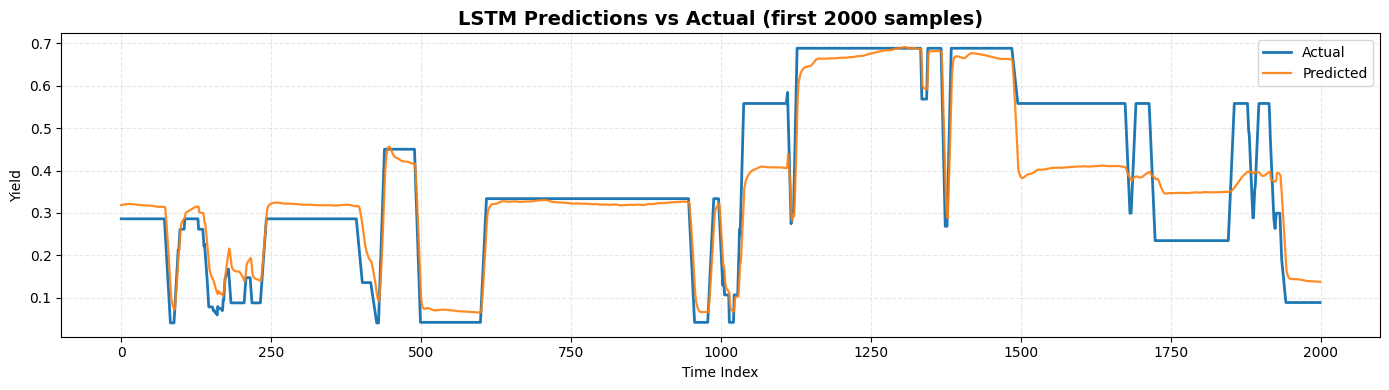

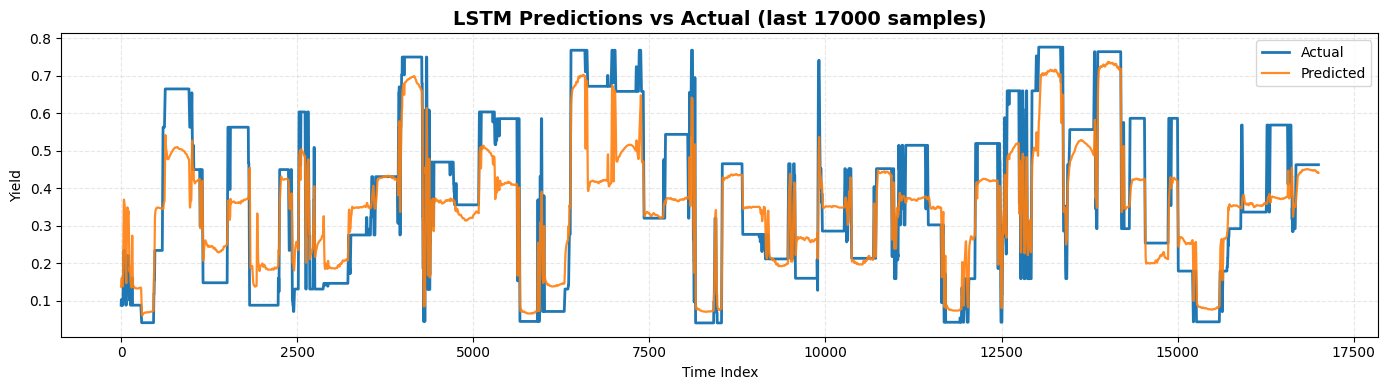

In [77]:
import matplotlib.pyplot as plt
import pandas as pd

yt = np.array(y_true).ravel()
yp = np.array(y_pred).ravel()

SMOOTH = 10
yt_s = pd.Series(yt).rolling(SMOOTH, min_periods=1).mean().values
yp_s = pd.Series(yp).rolling(SMOOTH, min_periods=1).mean().values

def plot_seq(actual, pred, title):
    plt.figure(figsize=(14,4))
    plt.plot(actual, label="Actual", linewidth=2)
    plt.plot(pred,   label="Predicted", linewidth=1.6, alpha=0.9)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Time Index")
    plt.ylabel("Yield")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

N = min(2000, len(yt_s)//2)

# First half
plot_seq(yt_s[:N], yp_s[:N],
         f"LSTM Predictions vs Actual (first {N} samples)")

# Second half
plot_seq(yt_s[N:], yp_s[N:],
         f"LSTM Predictions vs Actual (last {len(yt_s)-N} samples)")


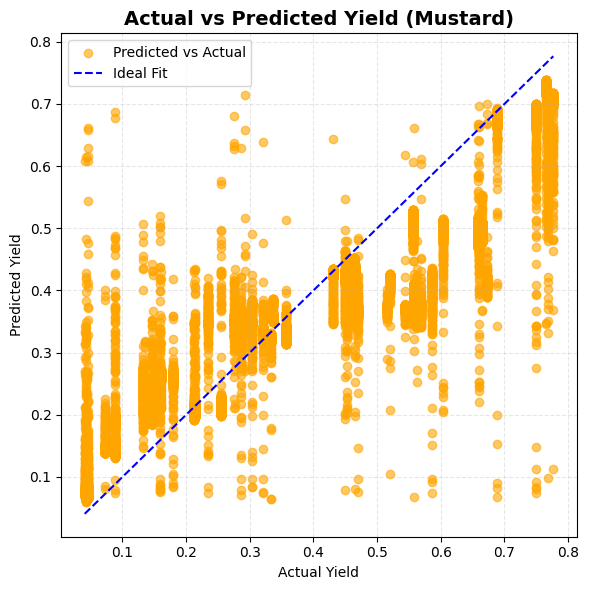

In [80]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, color='orange', label="Predicted vs Actual")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'b--', label="Ideal Fit")
plt.title("Actual vs Predicted Yield (Mustard)", fontsize=14, fontweight='bold')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


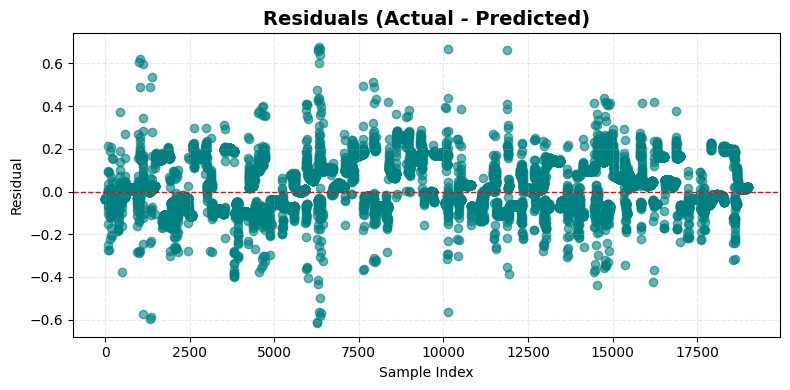

In [81]:
residuals = y_true - y_pred

plt.figure(figsize=(8,4))
plt.scatter(range(len(residuals)), residuals, color='teal', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals (Actual - Predicted)", fontsize=14, fontweight='bold')
plt.xlabel("Sample Index")
plt.ylabel("Residual")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


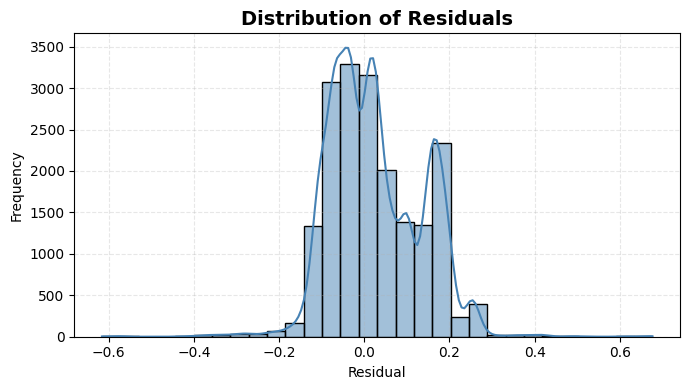

In [92]:
import seaborn as sns

plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=30, kde=True, color='steelblue')
plt.title("Distribution of Residuals", fontsize=14, fontweight='bold')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


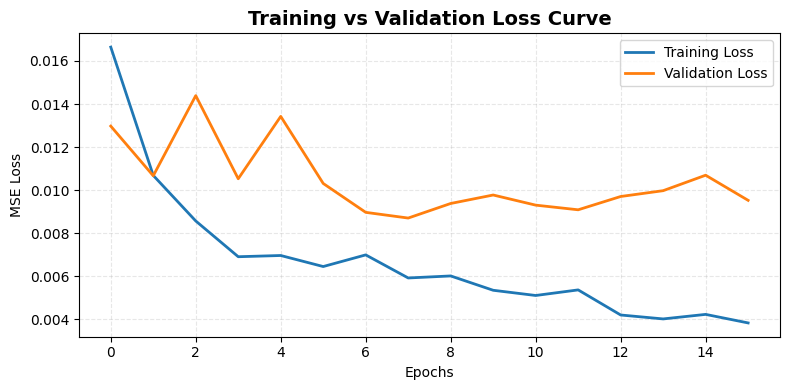

In [93]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss Curve", fontsize=14, fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
